In [1]:
import numpy
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from imblearn import over_sampling as os
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

Dataset : Sick Euthyroid  https://zenodo.org/record/61452#.WVxphHWLTRi <br>
Imbalanced dataのベンチマークを利用

In [2]:
# load dataset
X = numpy.load('data.npy')
y = numpy.load('label.npy')

print('y_train: {}'.format(Counter(y)))

#a * b行列のサイズ
print(X.shape)
print(y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
print('y_train: {}'.format(Counter(y_train)))
print('y_train: {}'.format(Counter(y_test)))

y_train: Counter({-1: 2870, 1: 293})
(3163, 42)
(3163,)
y_train: Counter({-1: 2167, 1: 205})
y_train: Counter({-1: 703, 1: 88})


前処理 : Oversamplingを適用

In [3]:
#Apply SMOTE
sm = os.SMOTE(random_state=RANDOM_STATE)
X_smt, y_smt = sm.fit_sample(X_train, y_train)
print('y_smt : {}'.format(Counter(y_smt)))

#Apply adasyn
ada = os.ADASYN(random_state=RANDOM_STATE)
X_ada, y_ada = ada.fit_sample(X_train, y_train)
print('y_ada : {}'.format(Counter(y_ada)))

y_smt : Counter({-1: 2167, 1: 2167})
y_ada : Counter({-1: 2167, 1: 2121})


PCA : 主成分分析

(2372, 2) (4334, 2) (4288, 2)
[ 10.390063  -11.0290325]


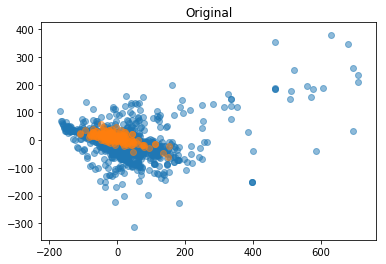

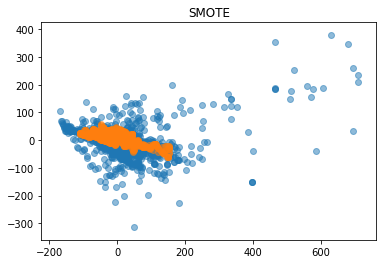

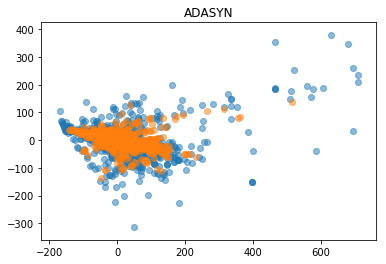

In [4]:
pca = PCA(n_components=2)

pca.fit(X_train)
pca.fit(X_smt)
pca.fit(X_ada)

pca_ori = pca.transform(X_train)
pca_smt = pca.transform(X_smt)
pca_ada = pca.transform(X_ada)

print(pca_ori.shape, pca_smt.shape, pca_ada.shape)
print(pca_ori[2371])

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.title("Original")
ax1.scatter(pca_ori[y_train == -1, 0], pca_ori[y_train == -1, 1], label="Class #-1", alpha=0.5)
ax1.scatter(pca_ori[y_train == 1, 0], pca_ori[y_train == 1, 1], label="Class #-1", alpha=0.5)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, sharey=ax1, sharex=ax1)
plt.title("SMOTE")
ax2.scatter(pca_smt[y_smt == -1, 0], pca_smt[y_smt == -1, 1], label="Class #-1", alpha=0.5)
ax2.scatter(pca_smt[y_smt == 1, 0], pca_smt[y_smt == 1, 1], label="Class #1", alpha=0.5)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111, sharey=ax1, sharex=ax1)
plt.title("ADASYN")
ax3.scatter(pca_ada[y_ada == -1, 0], pca_ada[y_ada == -1, 1], label="Class #-1", alpha=0.5)
ax3.scatter(pca_ada[y_ada == 1, 0], pca_ada[y_ada == 1, 1], label="Class #1", alpha=0.5)

plt.show()

学習 : Linear Support Vector Classificationを利用<br>
http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

In [5]:
#original
train_original = LinearSVC(random_state=RANDOM_STATE)
train_original.fit(X_train, y_train)

#SMOTE
train_smt = LinearSVC(random_state=RANDOM_STATE)
train_smt.fit(X_smt, y_smt)

#ADASYN
train_ada = LinearSVC(random_state=RANDOM_STATE)
train_ada.fit(X_ada, y_ada)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

評価 : classification repornt & Confusion matrix (混同行列)

In [6]:
# Test the classifier and get the prediction
y_pred_bal1 = train_original.predict(X_test)
y_pred_bal2 = train_smt.predict(X_test)
y_pred_bal3 = train_ada.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal1))
print (confusion_matrix(y_test, y_pred_bal1))
print("######################################################")
print(classification_report_imbalanced(y_test, y_pred_bal2))
print (confusion_matrix(y_test, y_pred_bal2))
print("######################################################")
print(classification_report_imbalanced(y_test, y_pred_bal3))
print (confusion_matrix(y_test, y_pred_bal3))

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.89      1.00      0.02      0.94      0.94      0.88       703
          1       1.00      0.02      1.00      0.04      0.94      0.90        88

avg / total       0.90      0.89      0.13      0.84      0.94      0.88       791

[[703   0]
 [ 86   2]]
######################################################
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.94      0.99      0.47      0.96      0.88      0.78       703
          1       0.82      0.47      0.99      0.59      0.88      0.76        88

avg / total       0.92      0.93      0.52      0.92      0.88      0.77       791

[[694   9]
 [ 47  41]]
######################################################
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.10      1.00      0.18      0.35      0.13       703
       